## **Problem 7: Transformers**

# Question 2:

# Part 1.

In [1]:
from transformers import AutoTokenizer, DataCollatorForLanguageModeling
from datasets import load_dataset
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning, module='seqeval.metrics.sequence_labeling')

# Load Persian Wikipedia dataset 
print("Loading Persian Wikipedia dataset...")
dataset = load_dataset("codersan/Persian-Wikipedia-Corpus")["train"]
print(f"Total articles: {len(dataset)}")

model_name = "HooshvareLab/bert-fa-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Select a random subset of the dataset (25%)
subset_ratio = 0.25
subset_size = int(len(dataset) * subset_ratio)
dataset = dataset.shuffle(seed=42).select(range(subset_size))
print(f"\nSubset selected: {subset_size} samples ({int(subset_ratio*100)}%)")

# Tokenize text for MLM
def tokenize_function(examples):
    return tokenizer(
        examples["Text"],
        truncation=False,
        return_special_tokens_mask=True
    )

tokenized_dataset = dataset.map(
    tokenize_function,
    batched=True,
    num_proc=1,
    remove_columns=dataset.column_names
)
print(f"Tokenized samples: {len(tokenized_dataset)}")

block_size = 256

# Group tokenized data into fixed-length blocks
def group_texts(examples):
    concatenated = {k: sum(examples[k], []) for k in examples}
    total_length = (len(concatenated["input_ids"]) // block_size) * block_size
    result = {
        k: [t[i:i+block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

grouped_dataset = tokenized_dataset.map(
    group_texts,
    batched=True,
    num_proc=1
)
print(f"Grouped dataset size: {len(grouped_dataset)}")

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.15
)

print("\n- MLM data preparation complete...")

Loading Persian Wikipedia dataset...
Total articles: 1160676

Subset selected: 290169 samples (25%)
Tokenized samples: 290169
Grouped dataset size: 110664

- MLM data preparation complete...


# Part 2.

Loading pre-trained BERT model...


Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Trainable parameters: 162942880


Step,Training Loss
500,2.764500
1000,2.793300
1500,2.781700
2000,2.795500
2500,2.789200
3000,2.769100
3500,2.778800
4000,2.779500
4500,2.762000
5000,2.769600


Fine-tuning complete.
Model saved to: ./fine_tuned_bert_mlm


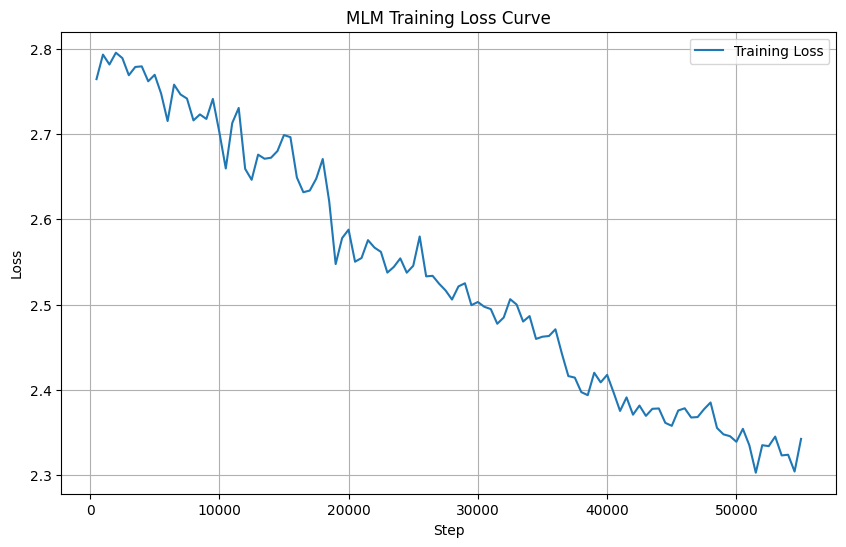

In [3]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoModelForMaskedLM, TrainingArguments, Trainer

# Load pre-trained BERT model for MLM
print("Loading pre-trained BERT model...")
model = AutoModelForMaskedLM.from_pretrained(model_name)
param_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {param_count}")

# Define training arguments
training_args = TrainingArguments(
    output_dir="./bert-mlm-fine-tuned",
    overwrite_output_dir=True,
    per_device_train_batch_size=6,
    num_train_epochs=3,
    save_steps=10000,
    save_total_limit=2,
    logging_steps=500,
    report_to="none",
    fp16=torch.cuda.is_available()
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=grouped_dataset,
    data_collator=data_collator
)
trainer.train()

print("Fine-tuning complete.")

# Step 5: Save the fine-tuned model
save_path = "./fine_tuned_bert_mlm"
trainer.save_model(save_path)
print(f"Model saved to: {save_path}")

# Extract training log and plot loss
log_history = trainer.state.log_history
loss_entries = [{"step": log["step"], "loss": log["loss"]} for log in log_history if "loss" in log]

if loss_entries:
    log_df = pd.DataFrame(loss_entries)
    plt.figure(figsize=(10, 6))
    plt.plot(log_df["step"], log_df["loss"], label="Training Loss")
    plt.title("MLM Training Loss Curve")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    plt.show()
else:
    print("No training loss found in log history.")

# Part 3.

In [4]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, Trainer, TrainingArguments
from datasets import Dataset
from seqeval.metrics import classification_report, f1_score, accuracy_score
import torch
import numpy as np
import random
import warnings
warnings.filterwarnings("ignore")

def load_clean_ner_data(tokens_path, labels_path):
    with open(tokens_path, "r", encoding="utf-8") as token_file, open(labels_path, "r", encoding="utf-8") as label_file:
        token_lines = token_file.readlines()
        label_lines = label_file.readlines()

    sentences, labels = [], []

    for t_line, l_line in zip(token_lines, label_lines):
        tokens = t_line.strip().split()
        lbls = l_line.strip().split()
        if len(tokens) == len(lbls) and len(tokens) > 0:
            sentences.append([t.strip() for t in tokens])
            labels.append([l.strip().lower().replace("_", "-") for l in lbls])
    return sentences, labels

# Read and merge ARMAN & PEYMA datasets
arman_sent, arman_lab = load_clean_ner_data("arman-tokens.txt", "arman-labels.txt")
peyma_sent, peyma_lab = load_clean_ner_data("peyma-tokens.txt", "peyma-labels.txt")
all_sentences = arman_sent + peyma_sent
all_labels = arman_lab + peyma_lab

# Combine and shuffle all data, then split into train (%80) and test (%20) sets
combined = list(zip(all_sentences, all_labels))
random.seed(42)
random.shuffle(combined)
split_idx = int(0.8 * len(combined))
train_sentences, train_labels = zip(*combined[:split_idx])
test_sentences, test_labels = zip(*combined[split_idx:])

all_labels_unique = sorted(set(l for seq in (train_labels + test_labels) for l in seq))
label2id = {l: i for i, l in enumerate(all_labels_unique)}
id2label = {i: l for l, i in label2id.items()}
print("Total Labels:", all_labels_unique)

# Load tokenizer from base Persian BERT and model from fine-tuned MLM
model_name = "HooshvareLab/bert-fa-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(
    "./fine_tuned_bert_mlm",
    num_labels=len(label2id),
    label2id=label2id,
    id2label=id2label
).to("cuda")

def tokenize_and_align_labels(example):
    # Tokenize with word alignment and padding
    tokenized = tokenizer(
        example["tokens"],
        is_split_into_words=True,
        truncation=True,
        padding="max_length",
        max_length=128
    )
    word_ids = tokenized.word_ids()   # Map tokens to word indices
    labels = []
    previous_word_idx = None

    for word_idx in word_ids:
        if word_idx is None:
            labels.append(-100)
        elif word_idx != previous_word_idx:
            labels.append(label2id[example["ner_tags"][word_idx]])
        else:
            labels.append(-100)
        previous_word_idx = word_idx
    tokenized["labels"] = labels
    return tokenized

# Convert token-label pairs to Hugging Face datasets
train_dataset = Dataset.from_dict({"tokens": train_sentences, "ner_tags": train_labels})
test_dataset = Dataset.from_dict({"tokens": test_sentences, "ner_tags": test_labels})

train_dataset = train_dataset.map(tokenize_and_align_labels, remove_columns=["tokens", "ner_tags"])
test_dataset = test_dataset.map(tokenize_and_align_labels, remove_columns=["tokens", "ner_tags"])

# Configure and launch BERT NER training
training_args = TrainingArguments(
    output_dir="./bert-ner-fa",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    logging_dir="./logs",
    logging_steps=500,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
)
trainer.train()

# Predict on test set 
predictions, labels, _ = trainer.predict(test_dataset)
pred_tags = np.argmax(predictions, axis=2)

true_labels = [[id2label[l] for l in label if l != -100] for label in labels]
pred_labels = [[id2label[p] for p, l in zip(pred_seq, label_seq) if l != -100]
               for pred_seq, label_seq in zip(pred_tags, labels)]

# compute evaluation metrics
accuracy = 100 * accuracy_score(true_labels, pred_labels)
f1 = 100 * f1_score(true_labels, pred_labels, average="weighted")

print(f"\nAccuracy: {accuracy:.4f}%")
print(f"F1_Score: {f1:.4f}%")
print(classification_report(true_labels, pred_labels))

Total Labels: ['b-dat', 'b-event', 'b-fac', 'b-loc', 'b-mon', 'b-org', 'b-pct', 'b-per', 'b-pers', 'b-pro', 'b-tim', 'i-dat', 'i-event', 'i-fac', 'i-loc', 'i-mon', 'i-org', 'i-pct', 'i-per', 'i-pers', 'i-pro', 'i-tim', 'o']


Some weights of BertForTokenClassification were not initialized from the model checkpoint at ./fine_tuned_bert_mlm and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/26417 [00:00<?, ? examples/s]

Map:   0%|          | 0/6605 [00:00<?, ? examples/s]

Step,Training Loss
500,0.218800
1000,0.119100
1500,0.091600
2000,0.079300
2500,0.073800
3000,0.062900
3500,0.044200
4000,0.029000
4500,0.027200
5000,0.026100



Accuracy: 99.2438%
F1_Score: 94.2095%
              precision    recall  f1-score   support

           _       0.94      0.94      0.94     10390
         dat       0.82      0.80      0.81       357
       event       0.96      0.97      0.97       396
         fac       0.94      0.99      0.97       281
         loc       0.96      0.95      0.96      3238
         mon       0.92      0.96      0.94       112
         org       0.95      0.96      0.95      3939
         pct       0.92      0.85      0.88        71
         per       0.90      0.85      0.88       925
        pers       0.94      0.99      0.97      1855
         pro       0.93      0.96      0.94       417
         tim       0.61      0.81      0.69        53

   micro avg       0.94      0.95      0.94     22034
   macro avg       0.90      0.92      0.91     22034
weighted avg       0.94      0.95      0.94     22034



In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, Trainer, TrainingArguments
from datasets import Dataset
from seqeval.metrics import classification_report, f1_score, accuracy_score
import torch
import numpy as np
import random
import warnings
warnings.filterwarnings("ignore")

def load_clean_ner_data(tokens_path, labels_path):
    with open(tokens_path, "r", encoding="utf-8") as token_file, open(labels_path, "r", encoding="utf-8") as label_file:
        token_lines = token_file.readlines()
        label_lines = label_file.readlines()

    sentences, labels = [], []

    for t_line, l_line in zip(token_lines, label_lines):
        tokens = t_line.strip().split()
        lbls = l_line.strip().split()
        if len(tokens) == len(lbls) and len(tokens) > 0:
            sentences.append([t.strip() for t in tokens])
            labels.append([l.strip().lower().replace("_", "-") for l in lbls])
    return sentences, labels

# Read and merge ARMAN & PEYMA datasets
arman_sent, arman_lab = load_clean_ner_data("arman-tokens.txt", "arman-labels.txt")
peyma_sent, peyma_lab = load_clean_ner_data("peyma-tokens.txt", "peyma-labels.txt")
all_sentences = arman_sent + peyma_sent
all_labels = arman_lab + peyma_lab

# Combine and shuffle all data, then split into train (%80) and test (%20) sets
combined = list(zip(all_sentences, all_labels))
random.seed(42)
random.shuffle(combined)
split_idx = int(0.8 * len(combined))
train_sentences, train_labels = zip(*combined[:split_idx])
test_sentences, test_labels = zip(*combined[split_idx:])

all_labels_unique = sorted(set(l for seq in (train_labels + test_labels) for l in seq))
label2id = {l: i for i, l in enumerate(all_labels_unique)}
id2label = {i: l for l, i in label2id.items()}
print("Total Labels:", all_labels_unique)

# Load tokenizer from base Persian BERT and model from fine-tuned MLM
model_name = "HooshvareLab/bert-fa-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(
    "./fine_tuned_bert_mlm",
    num_labels=len(label2id),
    label2id=label2id,
    id2label=id2label
).to("cuda")

def tokenize_and_align_labels(example):
    # Tokenize with word alignment and padding
    tokenized = tokenizer(
        example["tokens"],
        is_split_into_words=True,
        truncation=True,
        padding="max_length",
        max_length=128
    )
    word_ids = tokenized.word_ids()   # Map tokens to word indices
    labels = []
    previous_word_idx = None

    for word_idx in word_ids:
        if word_idx is None:
            labels.append(-100)
        elif word_idx != previous_word_idx:
            labels.append(label2id[example["ner_tags"][word_idx]])
        else:
            labels.append(-100)
        previous_word_idx = word_idx
    tokenized["labels"] = labels
    return tokenized

# Convert token-label pairs to Hugging Face datasets
train_dataset = Dataset.from_dict({"tokens": train_sentences, "ner_tags": train_labels})
test_dataset = Dataset.from_dict({"tokens": test_sentences, "ner_tags": test_labels})

train_dataset = train_dataset.map(tokenize_and_align_labels, remove_columns=["tokens", "ner_tags"])
test_dataset = test_dataset.map(tokenize_and_align_labels, remove_columns=["tokens", "ner_tags"])

# Configure and launch BERT NER training
training_args = TrainingArguments(
    output_dir="./bert-ner-fa",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    logging_dir="./logs",
    logging_steps=500,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
)
trainer.train()

# Predict on test set 
predictions, labels, _ = trainer.predict(test_dataset)
pred_tags = np.argmax(predictions, axis=2)

true_labels = [[id2label[l] for l in label if l != -100] for label in labels]
pred_labels = [[id2label[p] for p, l in zip(pred_seq, label_seq) if l != -100]
               for pred_seq, label_seq in zip(pred_tags, labels)]

# compute evaluation metrics
accuracy = 100 * accuracy_score(true_labels, pred_labels)
f1 = 100 * f1_score(true_labels, pred_labels, average="weighted")

print(f"\nAccuracy: {accuracy:.4f}%")
print(f"F1_Score: {f1:.4f}%")
print(classification_report(true_labels, pred_labels))


Total Labels: ['b-dat', 'b-event', 'b-fac', 'b-loc', 'b-mon', 'b-org', 'b-pct', 'b-per', 'b-pers', 'b-pro', 'b-tim', 'i-dat', 'i-event', 'i-fac', 'i-loc', 'i-mon', 'i-org', 'i-pct', 'i-per', 'i-pers', 'i-pro', 'i-tim', 'o']


Some weights of BertForTokenClassification were not initialized from the model checkpoint at ./fine_tuned_bert_mlm and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/26417 [00:00<?, ? examples/s]

Map:   0%|          | 0/6605 [00:00<?, ? examples/s]

Step,Training Loss
500,0.198700
1000,0.119500
1500,0.092000
2000,0.082400
2500,0.074300
3000,0.061300
3500,0.045800
4000,0.030400
4500,0.028900
5000,0.027000



Accuracy: 99.2821%
F1_Score: 94.4526%
              precision    recall  f1-score   support

           _       0.94      0.95      0.94     10390
         dat       0.81      0.81      0.81       357
       event       0.96      0.96      0.96       396
         fac       0.91      0.99      0.95       281
         loc       0.96      0.96      0.96      3238
         mon       0.95      0.95      0.95       112
         org       0.95      0.96      0.96      3939
         pct       0.92      0.83      0.87        71
         per       0.90      0.86      0.88       925
        pers       0.95      0.99      0.97      1855
         pro       0.95      0.98      0.96       417
         tim       0.76      0.77      0.77        53

   micro avg       0.94      0.95      0.94     22034
   macro avg       0.91      0.92      0.91     22034
weighted avg       0.94      0.95      0.94     22034

